# Computing prefecture-wise weighted averages of Pollution data

```{contents}
:local:
:depth: 4
```

## Preamble

### Imports

In [2]:
import os
import requests

import numpy as np
import pandas as pd
import plotnine as p9
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import Image
from collections import defaultdict
from shapely.geometry import box, Point
from mizani.formatters import date_format, percent_format, custom_format

### Pre-sets

In [3]:
tqdm.pandas()
p9.options.set_option('dpi', 600)
p9.options.set_option('figure_size', (4, 3))
p9.options.set_option('base_family', 'Georgia')
p9.theme_set(p9.theme_bw() + p9.theme(axis_text=p9.element_text(size=7),
                                      axis_title=p9.element_text(size=9),
                                      title=p9.element_text(size=11)))

## Data Loading

With daily data of the monitoring stations already collected, we are now going to collect two different sources of information that 
should enable us to compute population weighted averages of the station data per prefecture. The files will be the following:

+ Population density per municipality in Japan
+ Shapefiles of the said municipalities so as to be able to match the location of the monitoring station to a certain number of population

### Fetching the shapes

While several sources of shapefiles ara available online, I could not find any that included the same municipal codes that would enable a match with the population data obtained from the [official Japanese statistics site](https://www.e-stat.go.jp). 

This site, however, also provides a very precise collection of shapefiles for each of the 47 prefectures, with areas smaller than the municipal level (the one we are interested in), but with municipal-level identifiers, so we can _fuse_ the shapes to obtain exactly the shapes for all municipalities in Japan.

Let's do exactly that:

In [4]:
def get_download_url(code):
    url = 'https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015' \
         f'&code={code}&coordSys=1&format=shape&downloadType=5&datum=2000'
    return url

In [4]:
shapes_path = '../data/shapefiles/administrative_boundaries'
if not os.path.exists(f'{shapes_path}/municipality_shapes.shp'):
    municipality_shapes = []
    for i in tqdm(range(1, 48), total=47):
        municipality_shapes.append(
            gpd.read_file(get_download_url(str(i).zfill(2))).dissolve(by='CITY')
        )

    municipality_shapes = pd.concat(municipality_shapes).reset_index()[['PREF', 'CITY', 'geometry']]
    prefecture_shapes = municipality_shapes.dissolve(by='PREF').reset_index()[['PREF', 'geometry']]
    municipality_shapes.to_file(f'{shapes_path}/municipality_shapes.shp')
    prefecture_shapes.to_file(f'{shapes_path}/prefecture_shapes.shp')
else:
    municipality_shapes = gpd.read_file(f'{shapes_path}/municipality_shapes.shp')
    prefecture_shapes = gpd.read_file(f'{shapes_path}/prefecture_shapes.shp')

We now have the equivalent shapefiles grouped at the **municipal** and the **prefectural** level, leading to a map of Japan like the following:

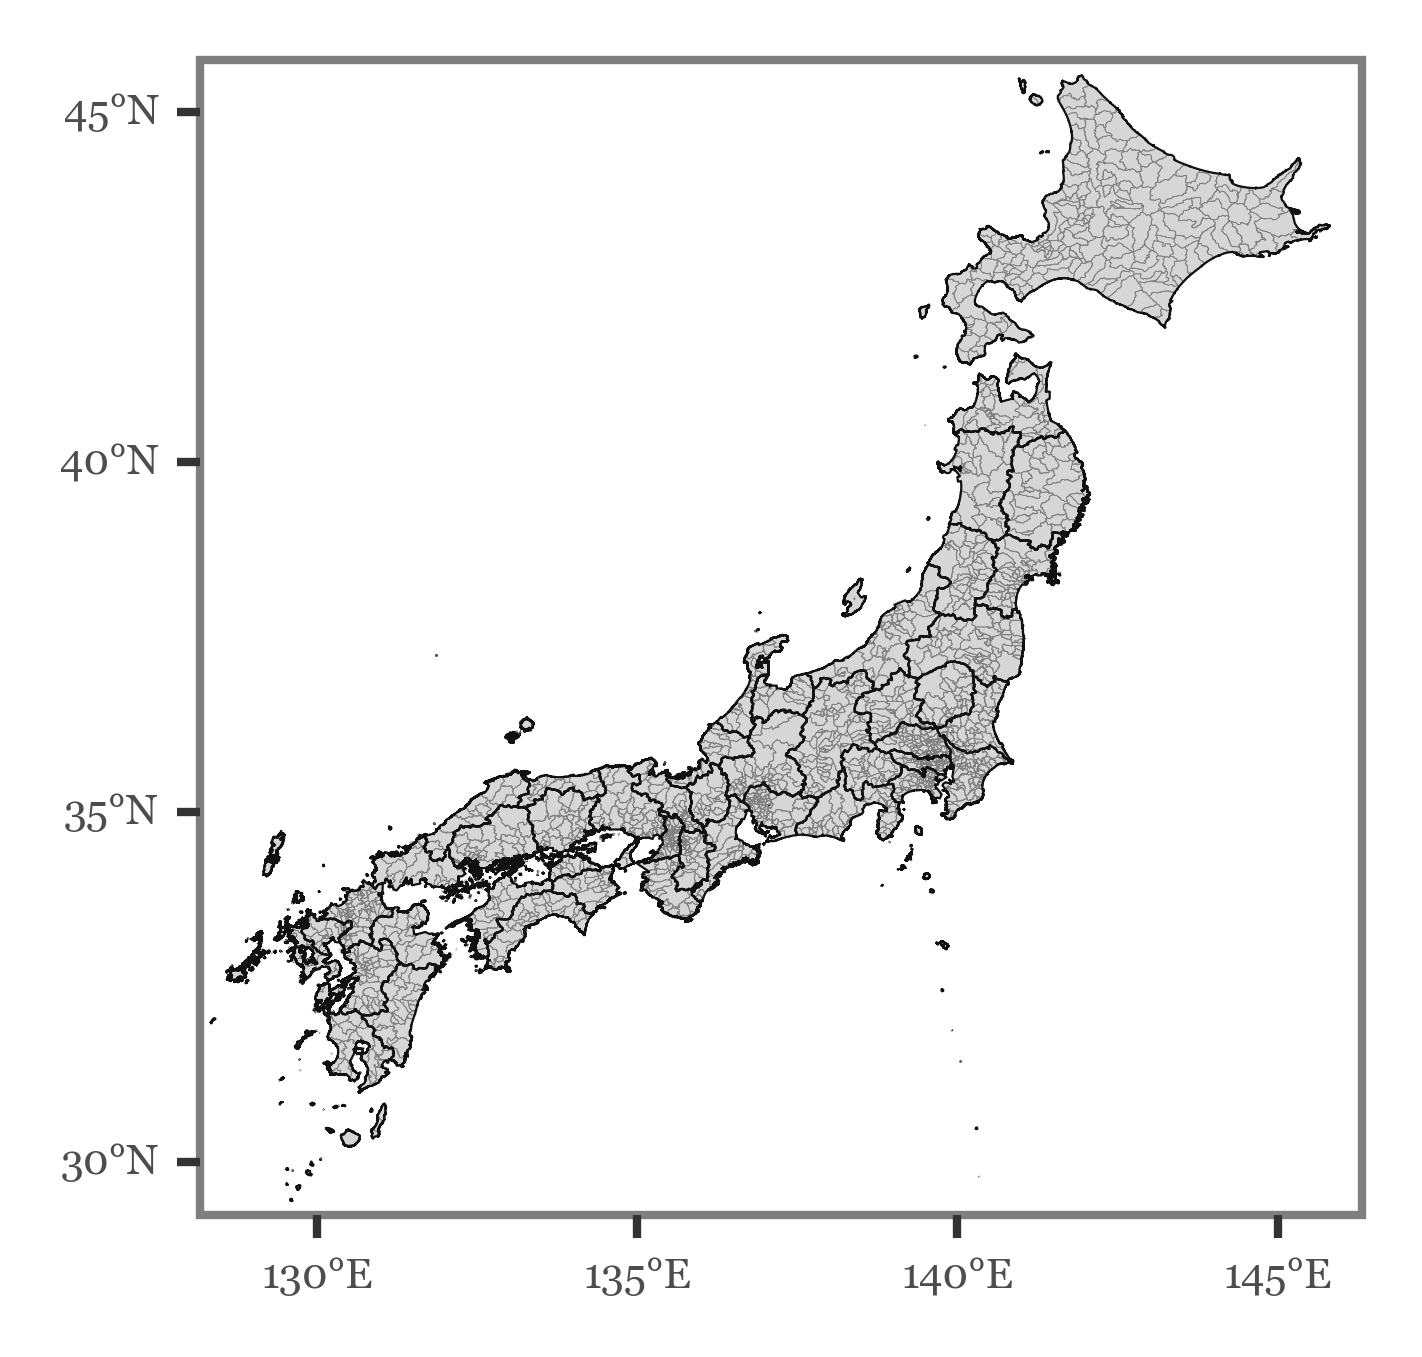

<ggplot: (683459918)>

In [5]:
(p9.ggplot(municipality_shapes) 
    + p9.geom_map(alpha=.2, size=.05, color='gray')
    + p9.geom_map(data=prefecture_shapes, size=.15, alpha=0)
    + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 45))
    + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(129, 145.5))
    + p9.theme(figure_size=(2.5, 2.5),
               axis_text=p9.element_text(size=5),
               panel_grid=p9.element_blank())
)

### Fetching municipalities populations

The same Statistics portal that we used to fetch the shapefiles provides an API to fetch different variables recorded by the government. It is necessary to register in the system to obtain an identifier that accompanies the requests to the API in order to be granted access. The documentation to use the API can be found [here](https://www.e-stat.go.jp/api/api-dev/how_to_use) (it's all in Japanese but it's manageable with Google translate).


We'll start by defining the API URL preceding the parameters specifying the version of the API we will be using (3.0) and the output we want (json):

In [7]:
API_URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'

I have already checked the variables I am interested in, although there are plenty more to choose. We will be fetching the following codes:

In [8]:
jp_api_codes = {'A1101': 'Total population (Both sexes)',
                'A110101': 'Total population (Male)',
                'A110102': 'Total population (Female)',
                'A1301': 'Total population (under 15)',
                'A130101': 'Population (under 15, Male)',
                'A130102': 'Population (under 15, Female)',
                'A1302': 'Total population (15-64)',
                'A130201': 'Population (15-64, Male)',
                'A130202': 'Population (15-64, Female)',
                'A1303': 'Total population (65 and over)',
                'A130301': 'Population (65 and over, Male)',
                'A130302': 'Population (65 and over, Female)',
                'A1405': 'Population (0-5, Total)',
                'A140501': 'Population (0-5, Male)',
                'A140502': 'Population (0-5, Female)',
                'A1416': 'Population (60 and over, Total)',
                'A141601': 'Population (60 and over, Male)',
                'A141602': 'Population (60 and over, Female)',
                'A1417': 'Population (70 and over, Total)',
                'A141701': 'Population (70 and over, Male)',
                'A141702': 'Population (70 and over, Female)',
                'A1420': 'Population (85 and over, Total)',
                'A142001': 'Population (85 and over, Male)',
                'A142002': 'Population (85 and over, Female)'
               }

I have saved my personal `appID` in a non-shared file in the root folder as `.appID`. Let's read it so as to include it in the request URL:

In [8]:
with open('../.appID', 'r') as fh:
    API_ID = fh.read()

We need to URL encode all the variables in the requests, which should be done by joining them with the `%2C` characters:

In [9]:
variables_string = '%2C'.join(list(jp_api_codes.keys()))

The full request will be the following:

In [10]:
url = (f'{API_URL}'                       # Main API URL
       f'?cdCat01={variables_string}'     # Specify the variables selected
       f'&appId={API_ID}'                 # Add the API ID to be allowed access 
        '&lang=E'                         # Specify the language to be English
        '&statsDataId=0000020201'         # Specify the dataset to be used
        '&cdTimeFrom=2015')               # Request data from the last census (2015)

In [11]:
r = requests.get(url)

In [12]:
full_population_df = (pd.DataFrame(r.json()
                      ['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
                      .loc[lambda dd: dd['@time'].str.startswith('2015')]
                      .drop(columns=['@tab', '@time', '@unit'])
                      .rename(columns={'@area': 'area_code'})
                      .pivot('area_code', '@cat01', '$')
                      .rename(columns=jp_api_codes)
)

I will keep an already processed version of this dataset in the repository as an easily accessible CSV table to ease future usage of the files.

In [13]:
full_population_df.to_csv('../data/population/municipal_population_stats.csv')

In [6]:
full_population_df = pd.read_csv('../data/population/municipal_population_stats.csv')

## Matching stations, municipalities, and populations

Since my main interest lies on relating the environmental variables to Kawasaki Disease incidence in Japan, I am going to use the municipal population of children under 5 years old to weight the importance of each municipal term in the prefecture averages:

In [7]:
jp_pops_kids = (full_population_df
                .reset_index()
                .rename(columns={'area_code': 'code'})
                .assign(code=lambda dd: dd.code.astype(str).str.zfill(5))
                .assign(population=lambda dd: dd['Population (0-5, Total)'].astype(int))
                [['code', 'population']]
)

In [8]:
jp_pops_full = (full_population_df
                .reset_index()
                .rename(columns={'area_code': 'code'})
                .assign(code=lambda dd: dd.code.astype(str).str.zfill(5))
                .assign(population=lambda dd: dd['Total population (Both sexes)'].astype(int))
                [['code', 'population']]
)

In [9]:
jp_munis = (municipality_shapes
            .reset_index()
            .assign(code=lambda dd: dd.PREF + dd.CITY.astype(str))
            [['PREF', 'CITY', 'code', 'geometry']]
            )

We can now load the monitoring stations information, and use their coordinates to assign a municipal boundary to each of them. This way, we will be able to average a value for each municipality using the values of the monitoring stations within its boundaries.

In [10]:
monitoring_stations = (pd.read_csv('../data/air_pollution/stations/doc/stations_info.csv')
                       .assign(geometry=lambda dd: [Point(np.array([x, y])) 
                                                     for x, y in zip(dd.longitude, dd.latitude)])
                       .pipe(lambda dd: gpd.GeoDataFrame(dd, geometry='geometry', crs='EPSG:4612'))
)

/Users/alfontal/miniforge3/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [11]:
station_munis = (gpd.sjoin(monitoring_stations, jp_munis, predicate='within')
                 .merge(jp_munis[['code', 'geometry']].rename(columns={'geometry': 'm_polygon'}))
                )

In [12]:
stations_per_city = station_munis.groupby(['PREF', 'CITY']).station_code.unique()

In [13]:
prefectures_map = (monitoring_stations
                    [['prefecture', 'prefecture_code']]
                    .drop_duplicates()
                    .set_index('prefecture_code')
                    ['prefecture']
                    .to_dict()
)

## Generating the daily averaged municipal estimates

In [14]:
municipal_pollution_dfs = []
for (pref, city), stations in tqdm(stations_per_city.items(), total=len(stations_per_city)):
    municipal_stations = []
    pref_name = prefectures_map[int(pref)]
    for station in stations:
        municipal_stations.append(
        pd.read_csv(f'../data/air_pollution/stations/clean/{pref}_{pref_name}/{station}.csv')
                    .assign(date=lambda dd: pd.to_datetime(dd.date))
        )
    
    municipal_stations = (pd.concat(municipal_stations)
                          .set_index('date')
                          .resample('D')
                          .mean())
    municipal_pollution_dfs.append(municipal_stations.assign(pref=pref, city=city))
    municipal_stations.round(3).to_csv(f'../data/air_pollution/municipalities/{pref}{city}.csv')
municipal_pollution_dfs = pd.concat(municipal_pollution_dfs)

100%|██████████| 905/905 [00:07<00:00, 128.60it/s]


## Generating the daily averaged prefectural estimates

Now, by using the municipal values and weighting them by different factors, we will be able to obtain prefecture-level estimates:

In [20]:
long_pollution_df = (municipal_pollution_dfs
                     .reset_index()
                     .melt(['date', 'pref', 'city'])
                     .dropna()
                     .eval('code = pref + city')
)

### Area-weighted averages

The first prefectural estimates we will estimate will be population agnostic, that is, each municipality will have a weight proportional to its area:

In [15]:
jp_areas = (jp_munis
            .eval('area = geometry.to_crs("+proj=cea").area / 10**6')
            [['code', 'area']]
)

In [ ]:
for prefecture, df in long_pollution_df.groupby('pref'):
    pref_df = (df.groupby(['date', 'variable'])
                 .progress_apply(lambda df: df
                                        .merge(jp_areas)
                                        .eval('weight = area / area.sum()')
                                        .eval('value = value * weight')
                                        .value.sum())
                 .rename('value')
                 .reset_index()
                 .pivot(index='date', columns='variable', values='value')
)
    pref_df.round(3).to_csv(f'../data/air_pollution/prefectures/area_weighted/{prefecture}.csv')

### Weighting by population of children under 5 years old

In this case we will weigh its municipality proportional to the relative amount of children under 5 years old living in it:

In [ ]:
for prefecture, df in long_pollution_df.groupby('pref'):
    pref_df = (df.groupby(['date', 'variable'])
                 .progress_apply(lambda df: df
                                        .merge(jp_pops_kids)
                                        .eval('weight = population / population.sum()')
                                        .eval('value = value * weight')
                                        .value.sum())
                 .rename('value')
                 .reset_index()
                 .pivot(index='date', columns='variable', values='value')
)
    pref_df.round(3).to_csv(f'../data/air_pollution/prefectures/under_5_weighted/{prefecture}.csv')

### Weighting by full population density

 In the last case, we will weigh each municipality proportional to the total population living in each term.

In [ ]:
for prefecture, df in long_pollution_df.groupby('pref'):
    pref_df = (df.groupby(['date', 'variable'])
                 .progress_apply(lambda df: df
                                        .merge(jp_pops_full)
                                        .eval('weight = population / population.sum()')
                                        .eval('value = value * weight')
                                        .value.sum())
                 .rename('value')
                 .reset_index()
                 .pivot(index='date', columns='variable', values='value')
)
    pref_df.round(3).to_csv(f'../data/air_pollution/prefectures/population_weighted/{prefecture}.csv')

## Visualizing the data

### Number of stations per variable per prefecture

While there are many stations, not all variables are measured with the same consistency. The following table shows how many stations measure each variable in each prefecture:

In [17]:
variable_map = {'NOX': 'NO$_{x}$',
                'PM25': 'PM$_{2.5}$',
                'SO2': 'SO$_2$',
                'CO2': 'CO$_2$',
                'SPM': 'PM$_{10}$'}

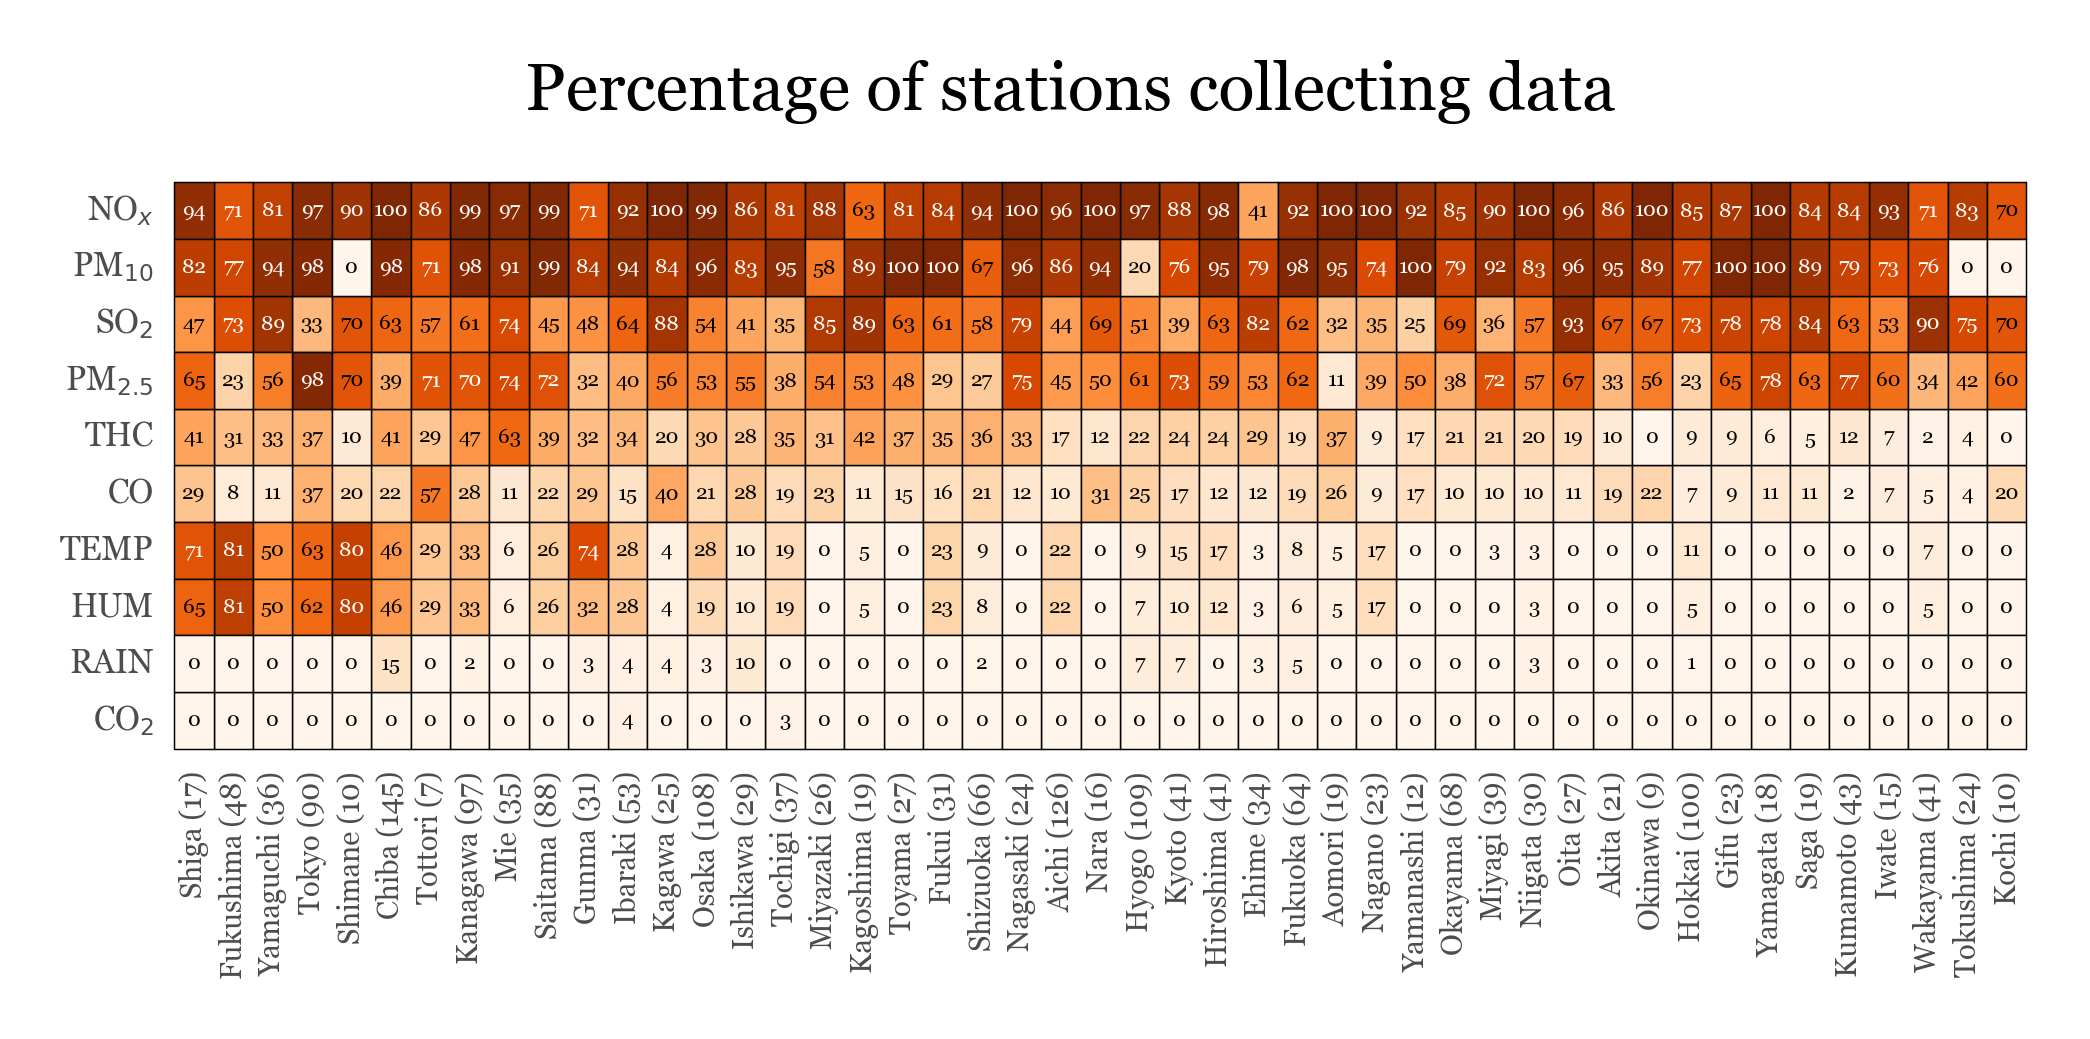

<ggplot: (694347155)>

In [22]:
(monitoring_stations
 .drop(columns=['station_code', 'latitude', 'longitude', 'altitude'])
 .groupby(['prefecture', 'prefecture_code'])
 .sum(numeric_only=True)
 .astype(int)
 .sort_values('prefecture_code')
 .apply(lambda x: x / monitoring_stations.groupby('prefecture_code').station_code.nunique())
 .applymap(lambda x: round(x * 100, 2))
 .reset_index()
 .melt(['prefecture', 'prefecture_code'])
 .query('not variable.isin(["NO", "NO2", "CH4", "NMHC"])')
 .replace(variable_map)
 .merge(monitoring_stations
        .groupby('prefecture_code')
        .station_code
        .nunique()
        .rename('n_stations')
        .reset_index())
 .assign(pref_name=lambda dd: dd.prefecture.str.split('-').str[0] + 
                                ' (' + dd.n_stations.astype(str) + ')')
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes(x='reorder(variable, value, ascending=True)',
                         y='reorder(pref_name, value, ascending=False)',
                         fill='value') 
                + p9.geom_tile(color='black')
                + p9.geom_text(p9.aes(label='value.round(0).astype(int)', color='value > 70'), size=2.5)      
                + p9.theme_minimal()
                + p9.scale_color_manual(values=['black', 'white'])
                + p9.scale_fill_continuous('Oranges')
                + p9.guides(fill=False, color=False)
                + p9.labs(x='', y='', title='Percentage of stations collecting data')
                + p9.coord_flip()
                + p9.theme(figure_size=(4, 1.25),
                           title=p9.element_text(size=8),
                           axis_text_x=p9.element_text(angle=90, size=3.5, margin={'t': -10}),
                           axis_text_y=p9.element_text(size=4, ha='right', margin={'r': -10}),
                           panel_grid=p9.element_blank())
)
)

Only NOx, SPM (or PM10), SO2 and PM2.5 are variables measured by over 50% of all stations, the rest are present in smaller numbers, which might limit the accuracy of the prefecture-level estimates:

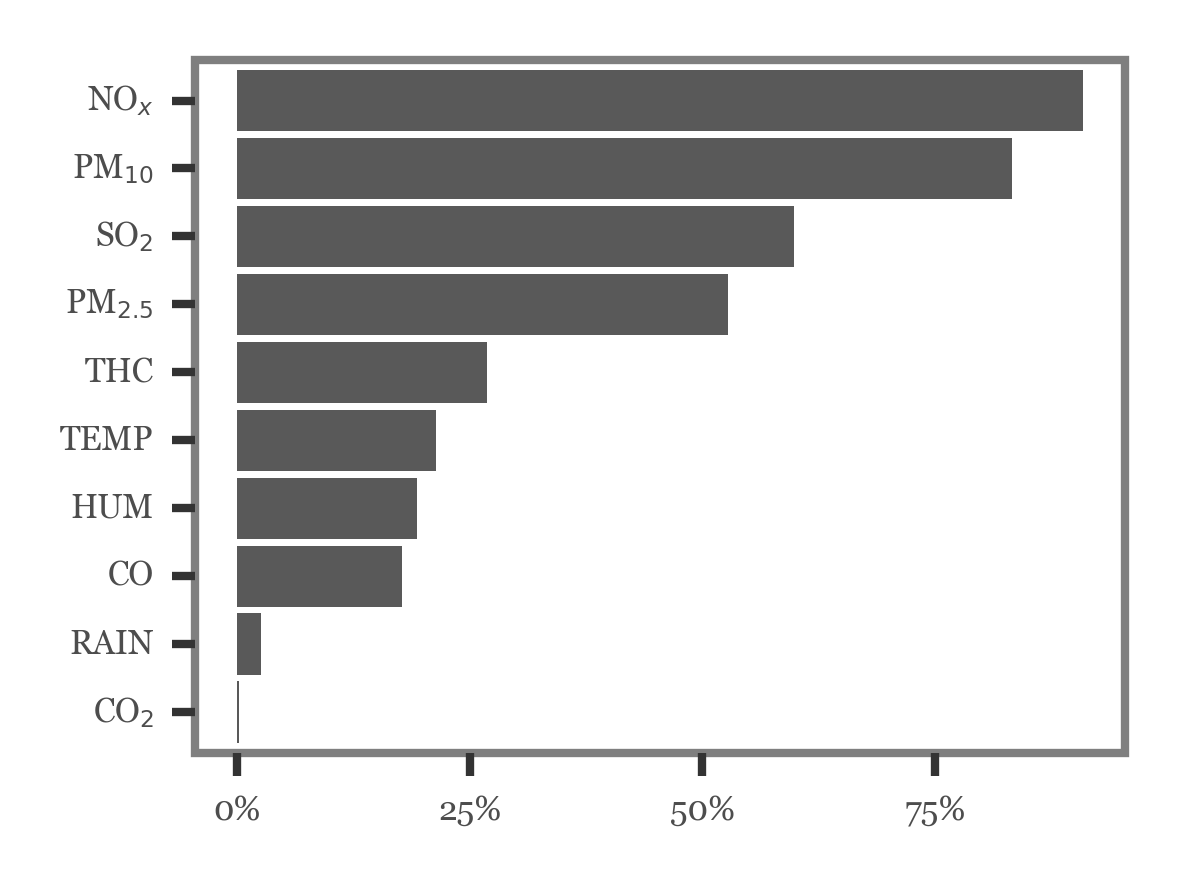

<ggplot: (694533102)>

In [23]:
(monitoring_stations
 .drop(columns=['station_code', 'latitude', 'longitude', 'altitude'])
 .groupby(['prefecture', 'prefecture_code'])
 .sum(numeric_only=True)
 .astype(int)
 .sum()
 .pipe(lambda x: x / monitoring_stations.station_code.nunique())
 .rename('ratio')
 .reset_index()
 .query('not index.isin(["NO", "NO2", "CH4", "NMHC"])')
 .replace(variable_map)
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('reorder(index, ratio)', 'ratio') 
                + p9.geom_col() 
                + p9.coord_flip()
                + p9.labs(x='', y='')
                + p9.scale_y_continuous(labels=percent_format()) 
                + p9.theme(figure_size=(2, 1.5),
                           axis_text=p9.element_text(size=4),
                           panel_grid=p9.element_blank())
 )
)

### Estimation of population coverage per prefecture

We will apply a quite naïve (and probably conservative) method to estimate the percentage of population 'covered' by 
monitoring stations: the % of population in a municipality with at least a station. The population living in
municipalities without any station will be considered as _uncovered_ by this metric (which might be a tad unfair as
municipal terms can often be really small).

In [24]:
jp_munis = jp_munis.assign(has_station=lambda dd: dd.code.isin(station_munis.code))

In [25]:
pop_coverage = (jp_munis
                .merge(jp_pops_full)
                .groupby('PREF')
                .apply(lambda dd: dd.query('has_station').population.sum() / dd.population.sum())
                .rename('pop_coverage')
                .reset_index()
                .set_index('PREF')
)

The prefecture of Tokyo has many small islands (barely inhabited) which distort completely the shape of the region. Let's get ride of those for the plots:

In [26]:
jp_munis = pd.concat([jp_munis.query("PREF!='13'"),
                      jp_munis.query("PREF=='13'")
                              .query('geometry.bounds.miny > 35')])

#### Population map

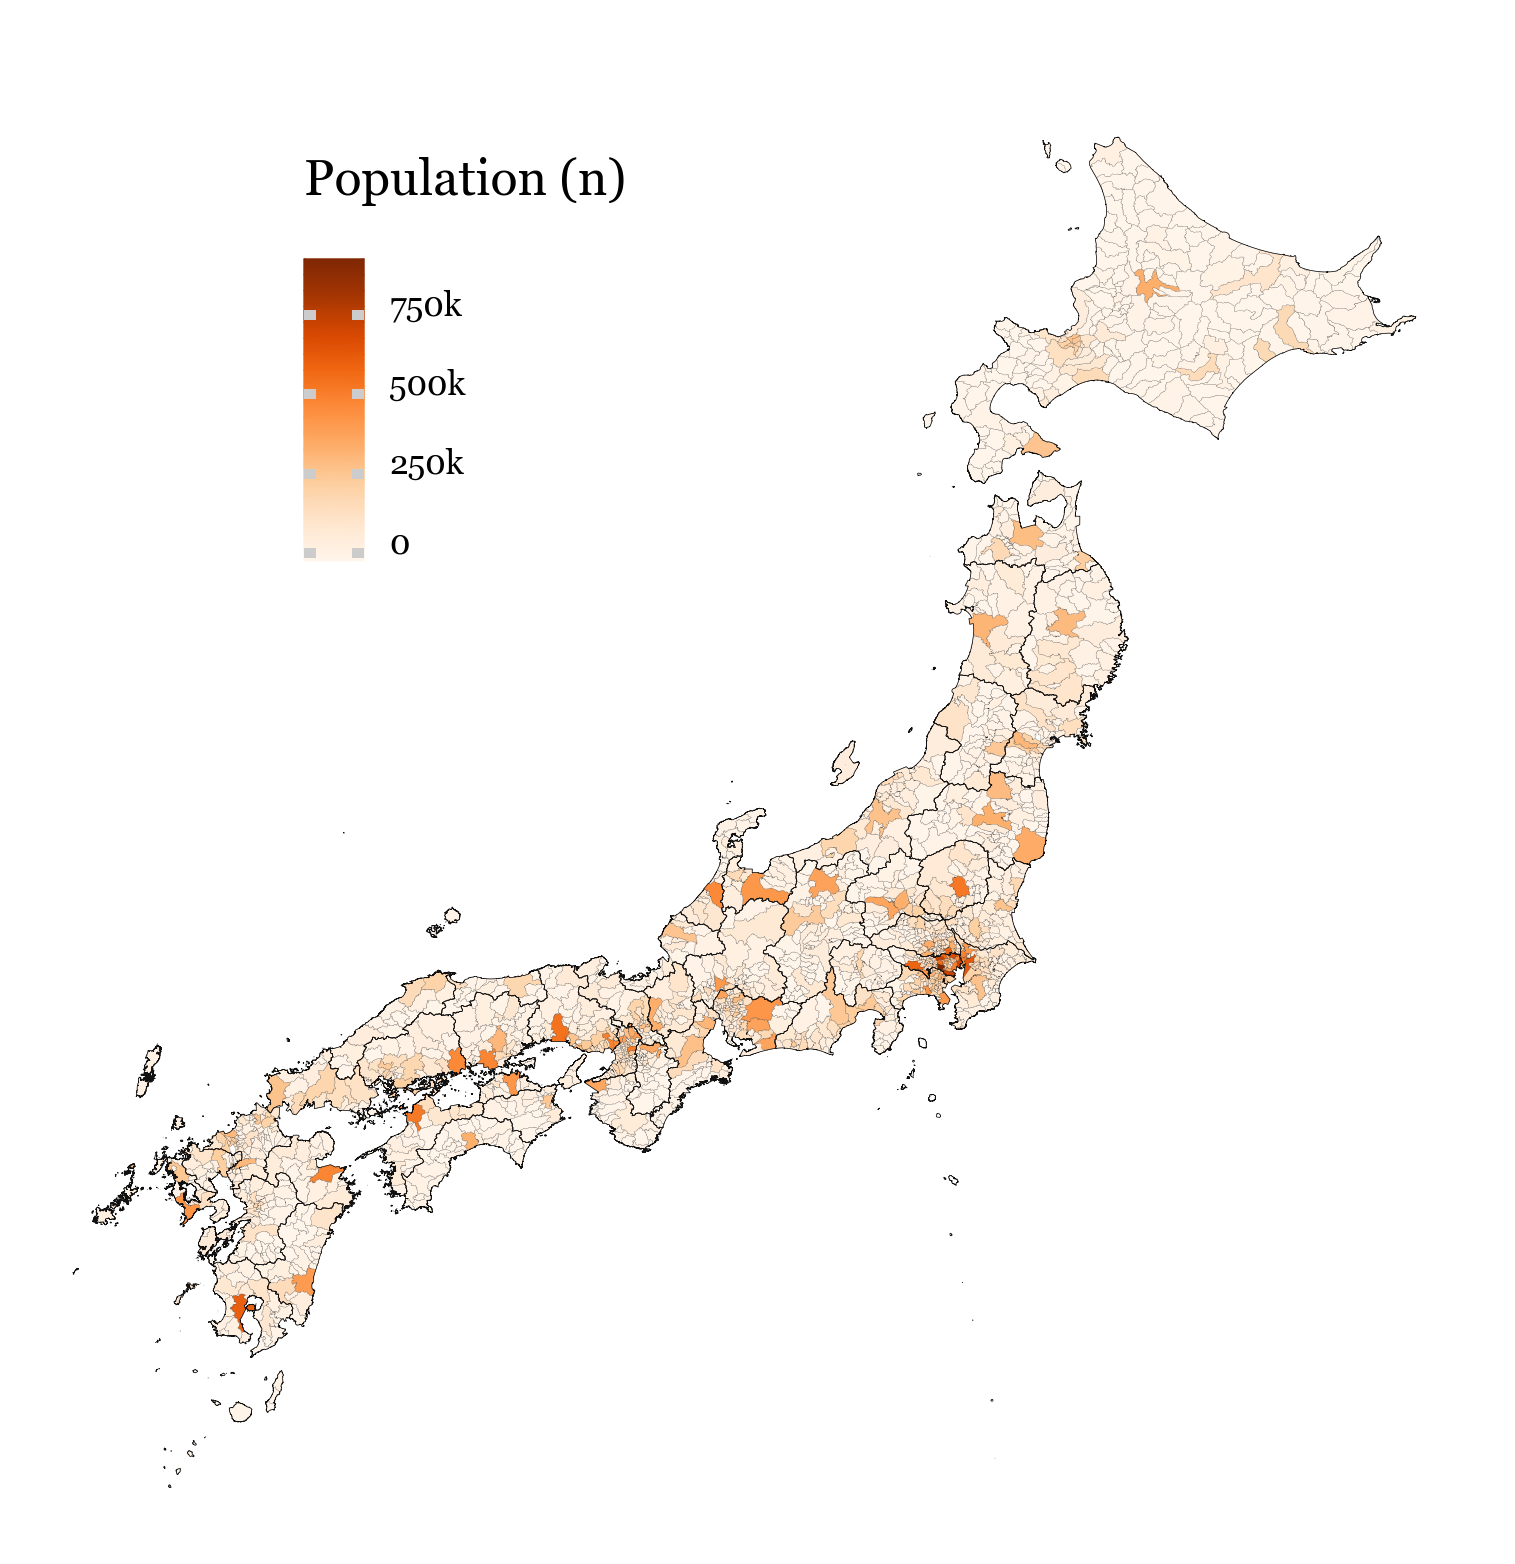

<ggplot: (694849431)>

In [27]:
(p9.ggplot(jp_munis.merge(jp_pops_full))
+ p9.geom_map(p9.aes(fill='population'), size=.01) 
+ p9.geom_map(data=prefecture_shapes, size=.05, alpha=0)
+ p9.scale_fill_continuous('Oranges', breaks=[0, 250_000, 500_000, 750_000], labels=['0', '250k', '500k', '750k'])
+ p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 45))
+ p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(129, 145.5))
+ p9.theme_void()
+ p9.labs(fill='Population (n)')
+ p9.theme(figure_size=(3, 3),
           legend_key_size=5,
           legend_position=(.35, .75),
           legend_direction='vertical',
           legend_title=p9.element_text(size=6),
           legend_text=p9.element_text(size=4, va='baseline'),)
)


#### Stations map

/Users/alfontal/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


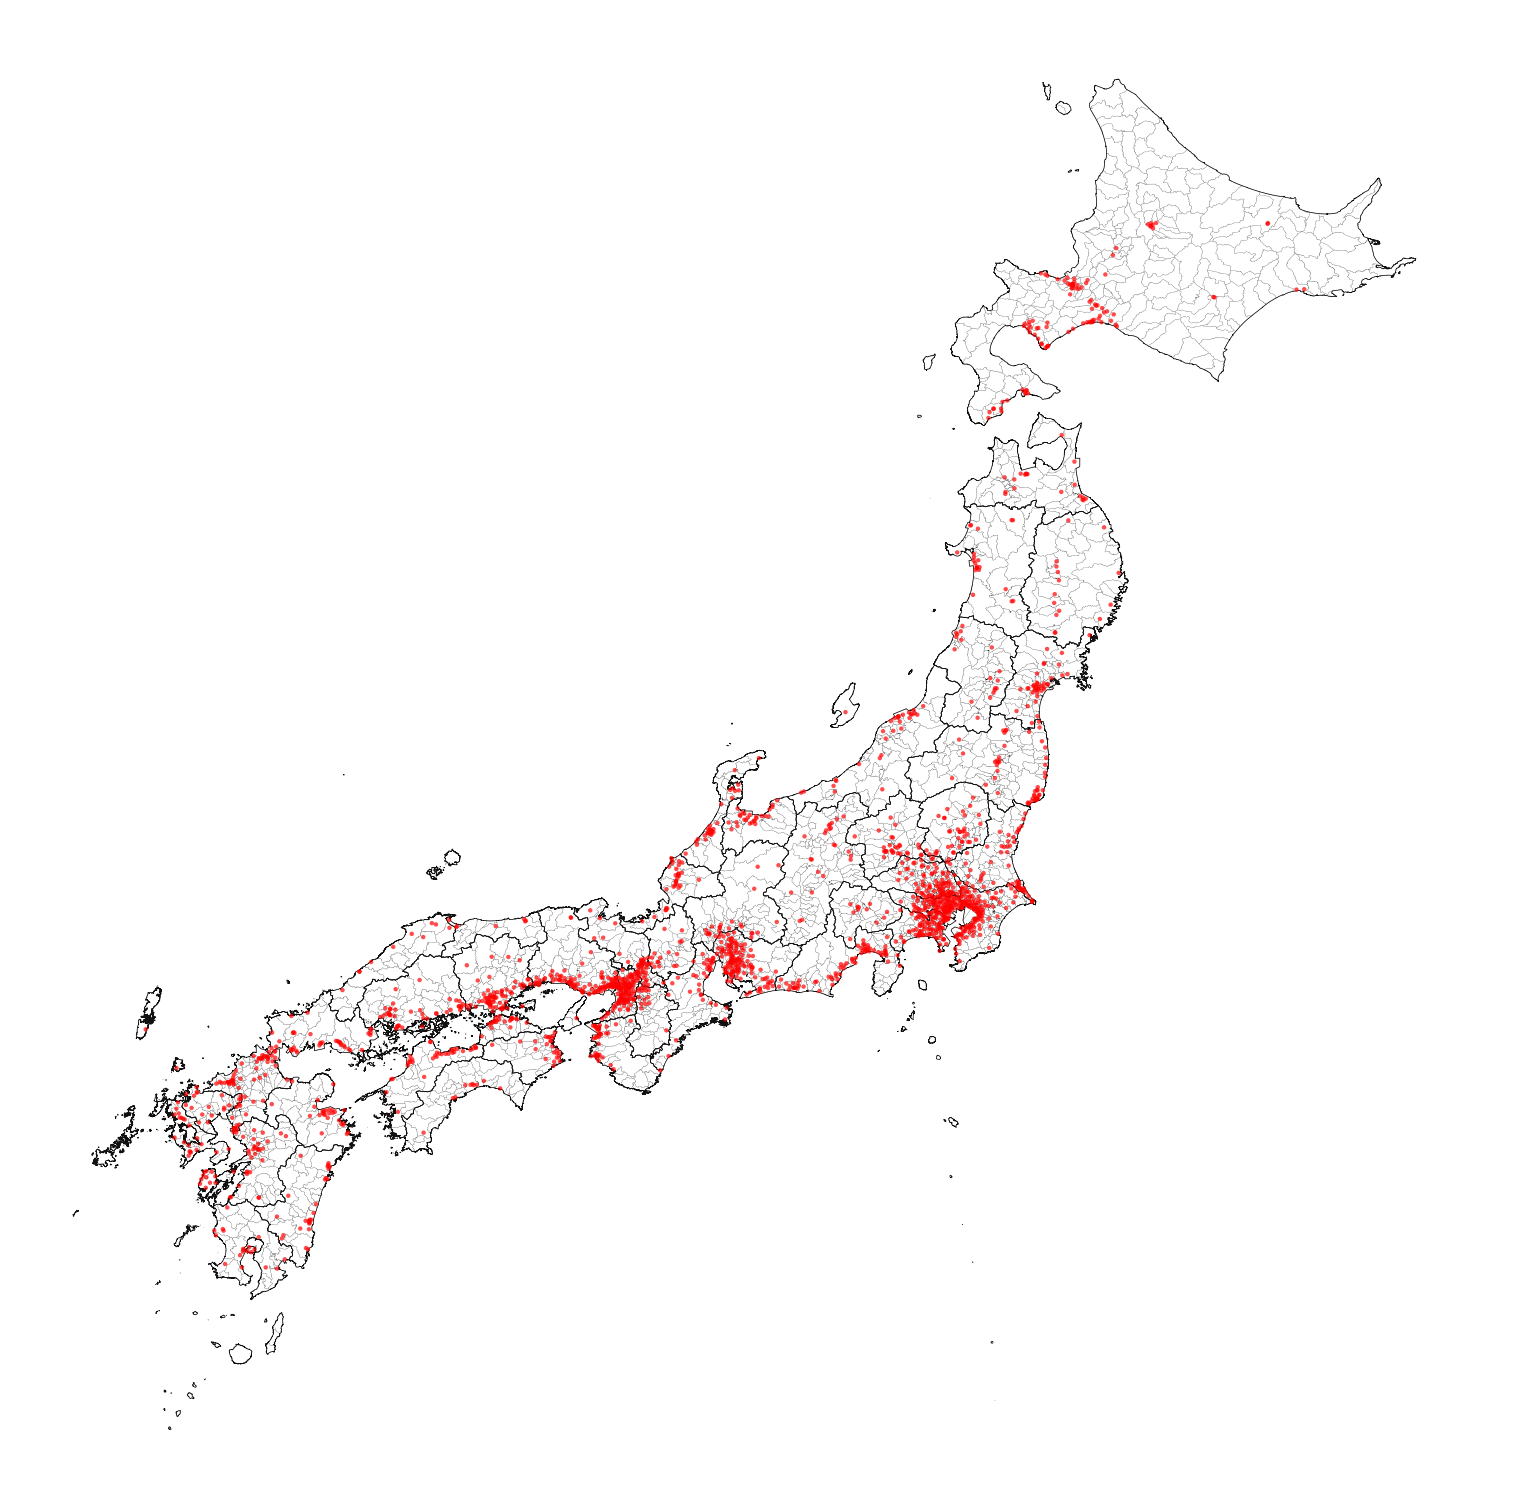

In [66]:
f = (p9.ggplot(jp_munis) 
    + p9.geom_map(size=.01, fill='white') 
    + p9.geom_map(data=prefecture_shapes, size=.05, alpha=0)
    + p9.geom_point(p9.aes(x='longitude', y='latitude'), data=monitoring_stations, size=.3, stroke=0, alpha=.7, color='red')
    + p9.scale_y_continuous(limits=(30, 45))
    + p9.scale_x_continuous(limits=(129, 145.5))
    + p9.guides(fill=False)
    + p9.theme_void()
    + p9.theme(figure_size=(3, 3),
               dpi=600)
).draw()

f.savefig('../data/air_pollution/stations/doc/stations_map.png')
f

#### Population coverage map

In [67]:
stats_df = defaultdict(list)
for i in range(1, 48):
    shape = jp_munis.query(f'PREF=="{str(i).zfill(2)}"')
    stations = monitoring_stations.query(f'prefecture_code=={i}')
    stats_df['prefecture'].append(prefectures_map[i].split('-')[0])
    stats_df['prefecture_code'].append(i)
    stats_df['n_stations'].append(len(stations))
    stats_df['coverage'].append((pop_coverage.loc[str(i).zfill(2)] * 100).round(2).values[0])
    bounds = shape.bounds.agg(['min', 'max']).values
    stats_df['ar'].append((bounds[1, 3] - bounds[0, 1]) / (bounds[1, 2] - bounds[0, 0]))
stats_df = pd.DataFrame(stats_df)

To actually visualize the prefecture by prefecture population coverage, I generated a figure for each prefecture which was
 later on merged together in a single figure with Inkscape. Notice how in most cases, stations and population go together, as most of the _stationless_ municipalities are usually those which are also lowly populated.

In [33]:

for i in tqdm(stats_df.sort_values('ar').prefecture_code):
    shape = jp_munis.query(f'PREF=="{str(i).zfill(2)}"')
    stations = monitoring_stations.query(f'prefecture_code=={i}')
    n_stations = len(stations)
    prefecture_name = prefectures_map[i].split('-')[0]
    coverage = (pop_coverage.loc[str(i).zfill(2)] * 100).round(2).values[0]
    bounds = shape.bounds.agg(['min', 'max']).values
    ar = (bounds[1, 3] - bounds[0, 1]) / (bounds[1, 2] - bounds[0, 0])
    f = (p9.ggplot(shape) 
                + p9.geom_map(p9.aes(fill='population'), size=.02) 
                + p9.geom_point(p9.aes(x='longitude', y='latitude'),
                                data=stations, size=.3, stroke=0)
                + p9.labs(x='', y='', fill='')
                + p9.guides(fill=False)
                + p9.scale_fill_continuous('Oranges')
                + p9.ggtitle(f'{prefecture_name} ({n_stations}, {coverage}%)')
                + p9.theme_void()
                + p9.theme(aspect_ratio=ar,
                           figure_size=(1, 1),
                           dpi=1000,
                           title=p9.element_text(size=4),)

 ).save(f'../data/doc/images/{str(i).zfill(2)}_{prefecture_name}.pdf', bbox_inches='tight', verbose=False)

100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


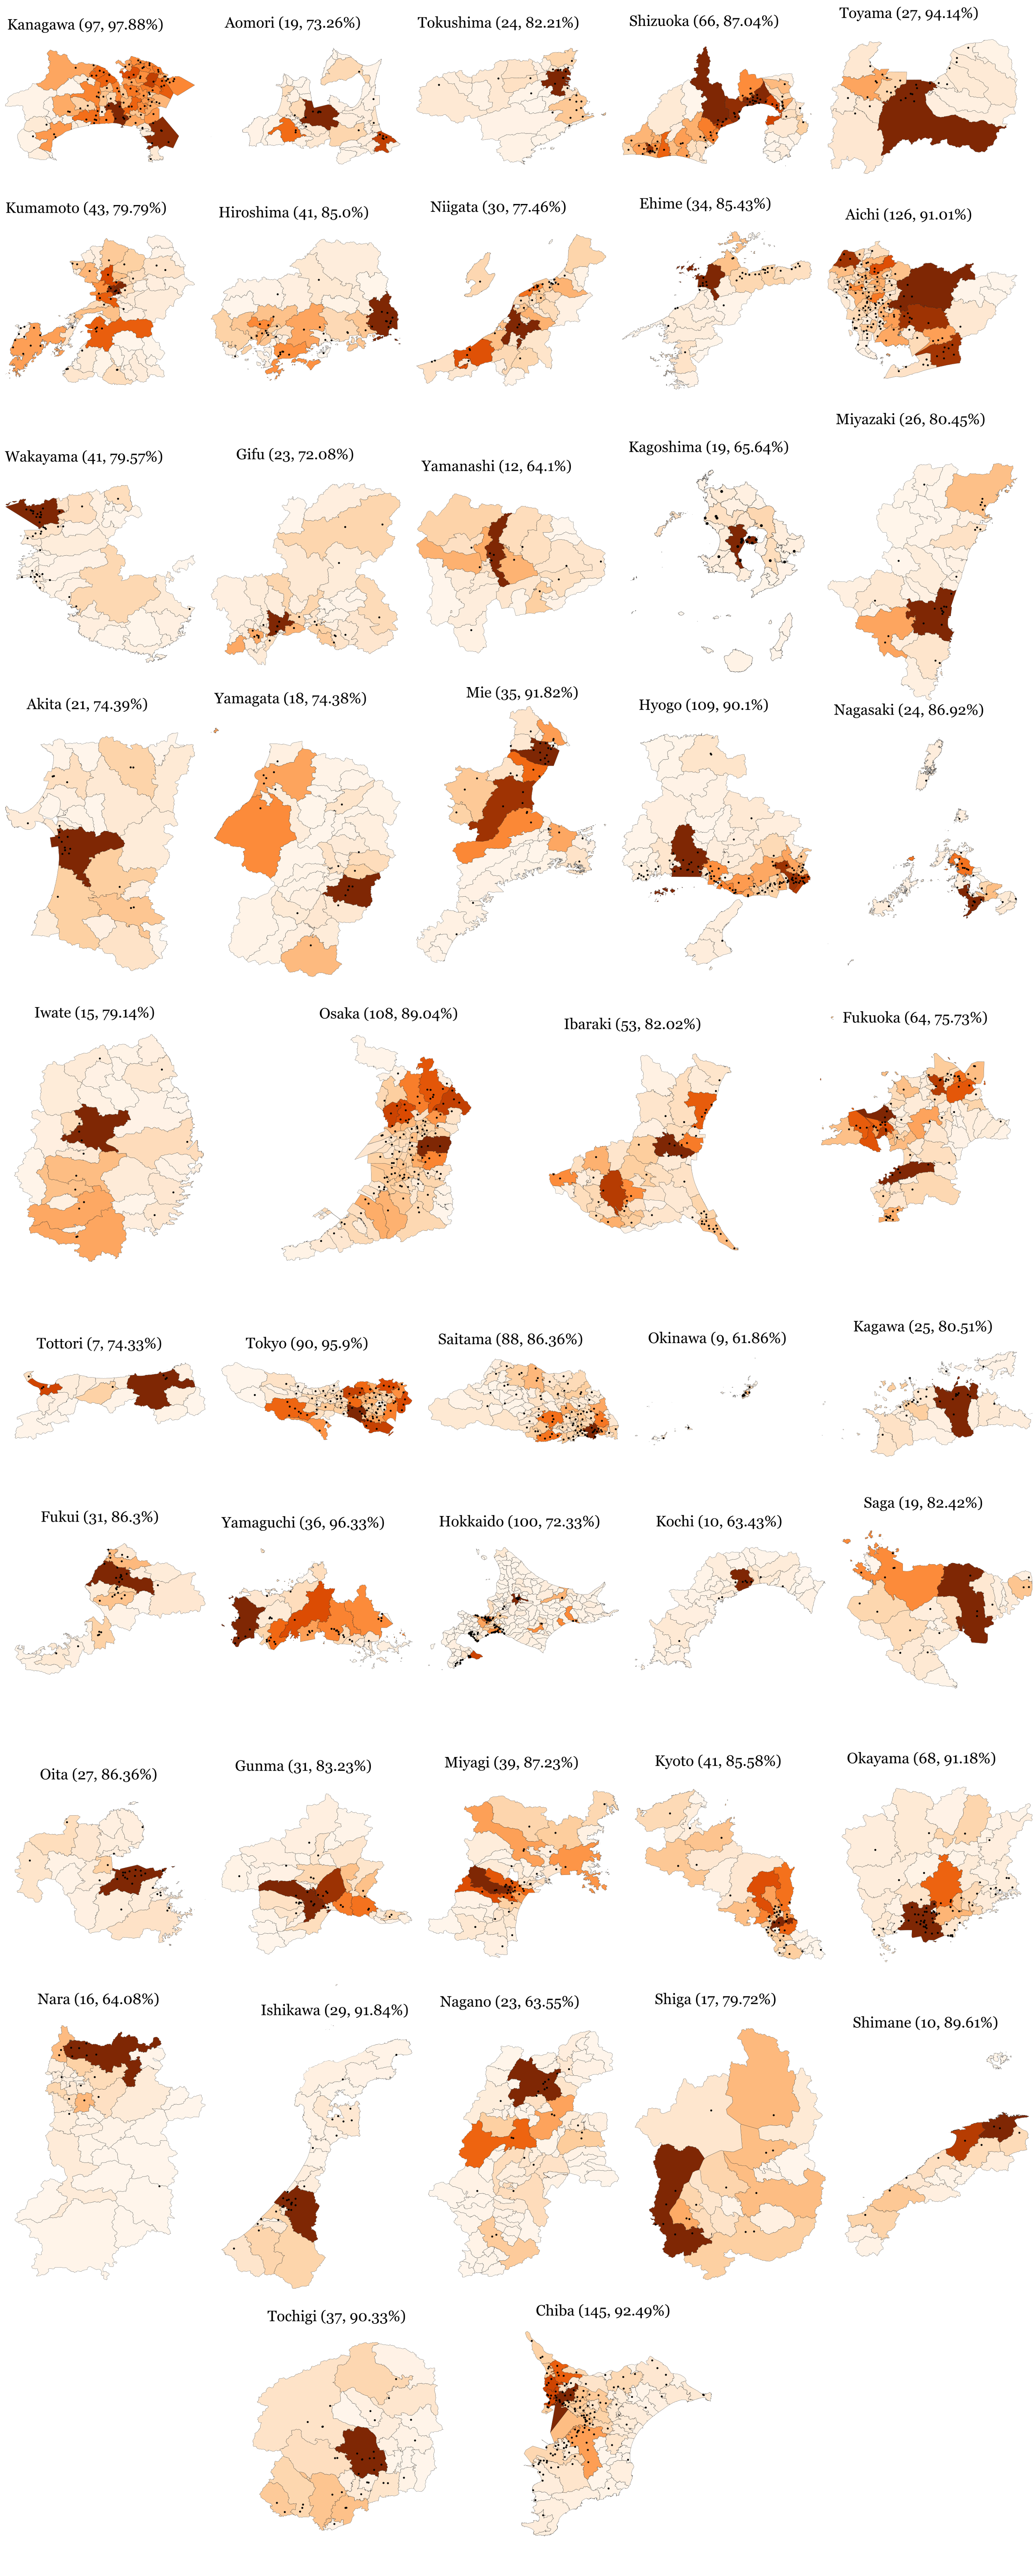

In [81]:
Image('../data/doc/images/prefectures_vertical.png')